This is the common problem set for Homework 2 from the spring quarter Network Theory class at UC Davis taught by Prof. Raissa D'Souza. The original assignment is at [http://mae.engr.ucdavis.edu/dsouza/Classes/253-S16/hw2.pdf](http://mae.engr.ucdavis.edu/dsouza/Classes/253-S16/hw2.pdf). Source code for this notebook is on github at [https://github.com/camillescott/ucd-ecs253](https://github.com/camillescott/ucd-ecs253). 

In [1]:
%pylab inline
%config InlineBackend.figure_format='retina'
import numpy as np
import networkx as nx
import seaborn as sns
sns.set_style('ticks')
sns.set_context('poster')

Populating the interactive namespace from numpy and matplotlib


# The Cayley Tree

A Cayley tree is a symmetric regular tree emanating from a central node of degree $k$.
Every node in the network has degree $k$, until we reach the nodes at the maximum
depth $d$ that have degree one and are called the leaves of the network. The figure
below shows a Cayley tree with $k = 3$ with depth $d = 4$.

<center>![cayley.png](cayley.png)</center>

For a Cayley degree of degree k and depth d calculate:

## Vertices at Exactly Distance 1

Let's start by considering a Cayley Tree at $d=1$ (which is actually just the star graph). The central vertex, in order to have degree $k$, must have exactly $k$ nodes attached directly to it. So, there are $k$ vertices at distance $1$ in this tree. If we grow the tree to higher $d$, the central node can have no more vertices attached, as it's already at degree $k$; we can then conclude, somewhat obviously, that there are $k$ vertices at exactly distance $1$.

## Vertices at Exactly Distance 2

Let's consider growing the tree to $d=2$. Each of the nodes at distance $1$ already has degree $1$, and so needs to have $k-1$ nodes attached in order to grow the tree to $d=2$. As there are $k$ of those, there must then be $k(k-1)$ nodes at exactly distance $2$.

## Vertices at Exactly Distance $l$

The logic for the general case follows from that for distance $2$: if we expand to $d=3$ we add another $k-1$ nodes to each leaf, giving us $k(k-1)^2$, and so on, meaning that there are $k(k-1)^{l-1}$ nodes at exactly distance $l$.

## Total Number of Vertices within Distance $l$

$$n(l) = 1 + \sum_{m=0..l-1}{k(k-1)^m}$$

## Small World

We can show the small world structure intuitively and empirically. For one, it's clear that $n(l)$ grows approximately geometrically with $d$ and $k$. To illustrate this further, I've plotted $n(l)$ for increasing $d$ with a range of $k$.

In [2]:
def n_nodes_cayley(d, k):
    n = 1
    for m in range(0,d-1):
        n += k * (k-1)**m
    return n

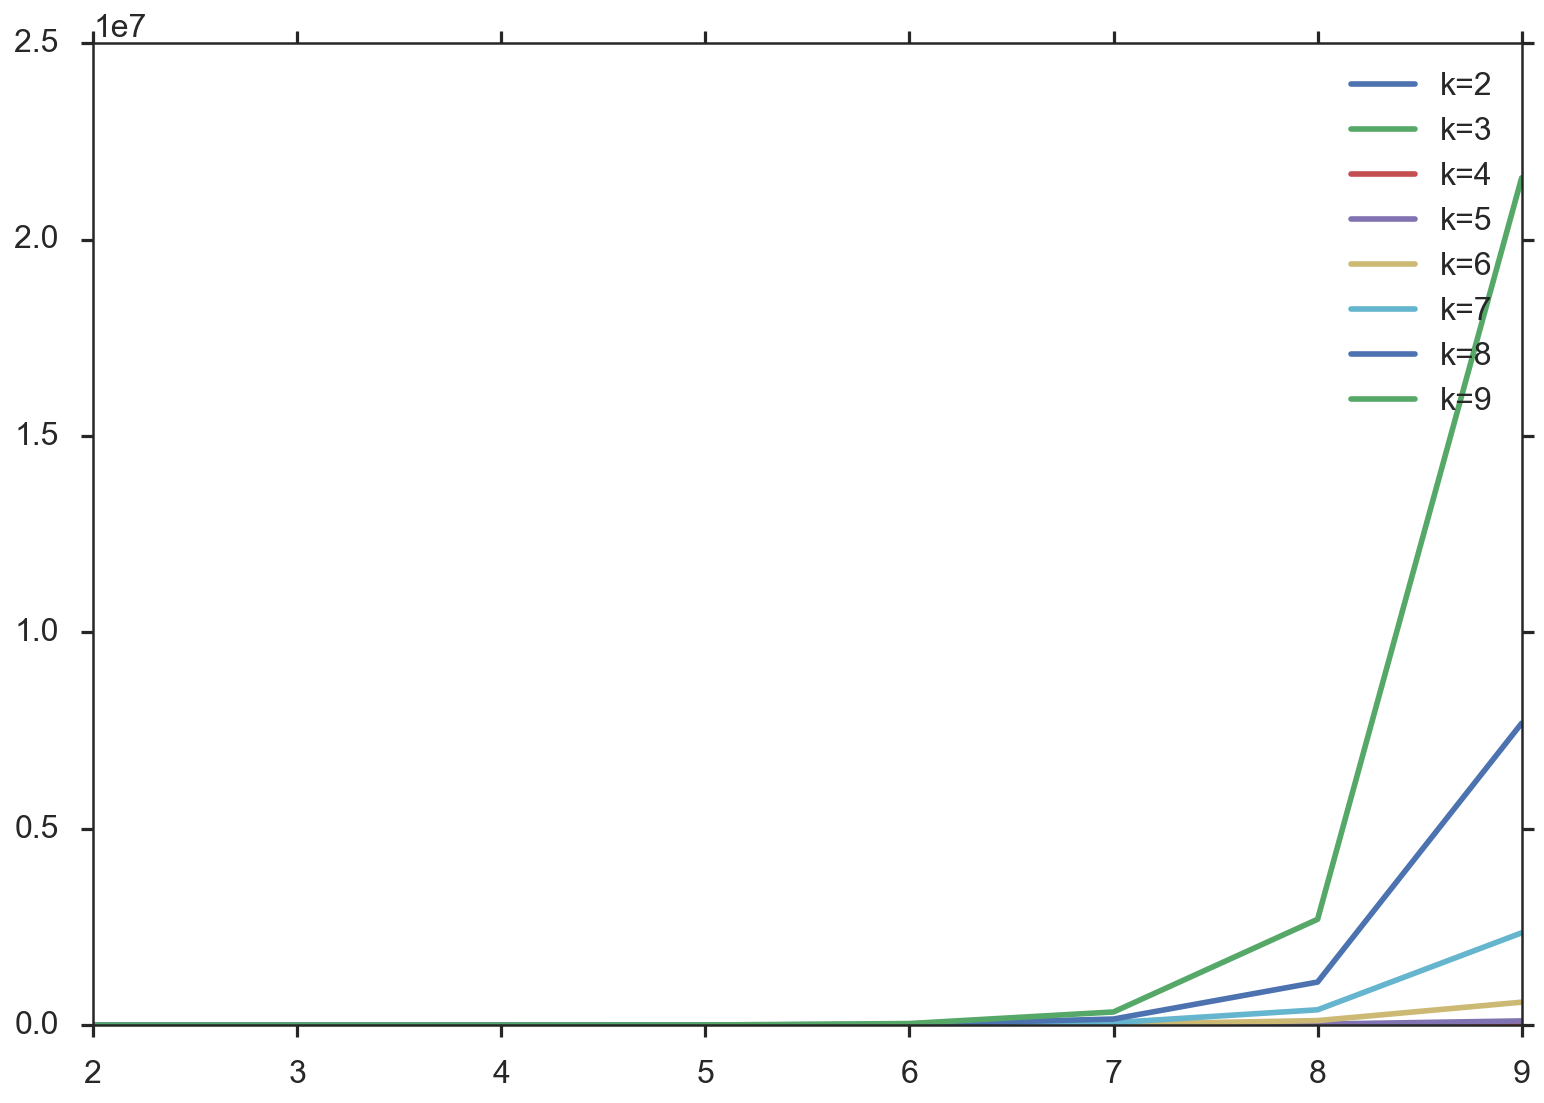

In [3]:
for k in range(2,10):
    D = range(2,10)
    plot(D, [n_nodes_cayley(d, k) for d in D], label='k={0}'.format(k))
legend()

It is also clear that the longest shortest path in this graph is always $2d$. With this and the scaling of $n(l)$, then, by approximation, we get that $d \approx log(n) / log(k)$ 

# Finite size scaling

To get $K_{max}$, we solve the definite integral over $p_k$. The equation we aim to solve is then:
$$\int_{1}^{K_{max}}{(\gamma - 1)k^{-\gamma}} = N^{-1} + 1$$.

If we expand the definite integral, we get:
$$\frac{(\gamma - 1)K_{max}^{1-\gamma}}{1-\gamma} - \frac{\gamma - 1}{1 - \gamma} = N^{-1} + 1$$

Simplifying a bit more:

$$\frac{-K_{max}^{1-\gamma}}{1-\gamma} = N^{-1}$$

# Analysis of a Real-world Network

I decided to attempt to build a network based on protein similarity of a group of genes. I started by downloading the FASTA-format sequence file with [this](http://www.uniprot.org/uniprot/?query=hox-a&sort=score&columns=id%2Centry%20name%2Creviewed%2Cprotein%20names%2Cgenes%2Corganism%2Clength%2Corganism-id%2Csequence) query. The sequences are HOXA1 proteins in many different species.

In [4]:
import screed
import pandas as pd
from networkx.drawing.nx_agraph import graphviz_layout

In [5]:
!head uniprot-hox-a.fasta

>sp|P49639|HXA1_HUMAN Homeobox protein Hox-A1 OS=Homo sapiens GN=HOXA1 PE=1 SV=2
MDNARMNSFLEYPILSSGDSGTCSARAYPSDHRITTFQSCAVSANSCGGDDRFLVGRGVQ
IGSPHHHHHHHHHHPQPATYQTSGNLGVSYSHSSCGPSYGSQNFSAPYSPYALNQEADVS
GGYPQCAPAVYSGNLSSPMVQHHHHHQGYAGGAVGSPQYIHHSYGQEHQSLALATYNNSL
SPLHASHQEACRSPASETSSPAQTFDWMKVKRNPPKTGKVGEYGYLGQPNAVRTNFTTKQ
LTELEKEFHFNKYLTRARRVEIAASLQLNETQVKIWFQNRRMKQKKREKEGLLPISPATP
PGNDEKAEESSEKSSSSPCVPSPGSSTSDTLTTSH
>sp|P09022|HXA1_MOUSE Homeobox protein Hox-A1 OS=Mus musculus GN=Hoxa1 PE=1 SV=2
MNSFLEYPILGSGDSGTCSARAYPSDHGITTFQSCAVSANSCGGDDRFLVGRGVQISSPH
HHHHHHHHHHPQTATYQTSGNLGISYSHSSCGPSYGAQNFSAPYGPYGLNQEADVSGGYP


Pull some meta data out of the sequence headers.

In [6]:
metadata = []
for record in screed.open('uniprot-hox-a.fasta'):
    tokens = record.name.split()
    _, entry_ID, entry_name = tokens[0].split('|')
    kvs = tokens[-3:]
    #_, _, species = kvs[0].partition('=')
    _, _, gene_name = kvs[0].partition('=')
    _, _, evidence = kvs[1].partition('=')
    metadata.append({'blast_ID': tokens[0],
                     'entry_ID': entry_ID,
                     'entry_name': entry_name.upper(),
                     'gene_name': gene_name.upper(),
                     'evidence': evidence})
metadata = pd.DataFrame(metadata)
metadata.set_index('blast_ID', inplace=True)

We'll do the alignments with NCBI BLAST. First, make the database:

In [19]:
!makeblastdb -dbtype prot -in uniprot-hox-a.fasta



Building a new DB, current time: 05/03/2016 11:37:15
New DB name:   uniprot-hox-a.fasta
New DB title:  uniprot-hox-a.fasta
Sequence type: Protein
Keep Linkouts: T
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 632 sequences in 0.0311999 seconds.


Now do find the alignments. We align the sequence file against itself to get all-by-all comparisons.

In [20]:
!blastp -query uniprot-hox-a.fasta -db uniprot-hox-a.fasta -outfmt 6 -out uniprot-hox-a.self.blastp.tab

In [7]:
def parse_blast(filename):
    results = pd.read_csv(filename, delimiter='\t',
                          names=['qseqid', 'sseqid', 'pident', 'length', 
                                 'mismatch', 'gapopen', 'qstart', 'qend',
                                 'sstart', 'send', 'evalue', 'bitscore'])
    return results

The alignments are easier to intrepret. To convert them into a network, we treat `qqeqid` as a node $u$, `sseqid` as a node $v$, and the alignment as an edge $e$. We can weight the edge by `pident`, the percent identity from the alignment.

In [8]:
alignments = parse_blast('uniprot-hox-a.self.blastp.tab')

In [9]:
alignments.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,sp|P49639|HXA1_HUMAN,sp|P49639|HXA1_HUMAN,100.00,335,0,0,1,335,1,335,0.0,695.0
1,sp|P49639|HXA1_HUMAN,tr|G3V6R3|G3V6R3_RAT,95.39,304,13,1,1,304,1,303,0.0,579.0
2,sp|P49639|HXA1_HUMAN,tr|B9EHK7|B9EHK7_MOUSE,94.75,305,15,1,1,304,1,305,0.0,579.0
3,sp|P49639|HXA1_HUMAN,tr|S7MQL1|S7MQL1_MYOBR,95.03,302,13,1,1,302,1,300,0.0,576.0
4,sp|P49639|HXA1_HUMAN,tr|L8I3B2|L8I3B2_9CETA,93.43,335,20,1,1,335,1,333,0.0,575.0


In [10]:
def get_graph(data, subset=None, GraphType=nx.MultiGraph):
    if subset is not None:
        data = data[subset]
    G = GraphType()
    G.add_weighted_edges_from(data[['qseqid', 'sseqid', 'pident']].to_records(index=False))
    return G

In [11]:
def plot_degree_dist(G):
    sns.distplot(list(nx.degree(G).values()))

In [12]:
def draw_graph(G):
    meta = metadata.ix[G.nodes()]
    cmap = sns.cubehelix_palette(5, start=.5, rot=-.75, as_cmap=True)
    
    #pos = graphviz_layout(G, )
    pos = nx.spring_layout(G, k=0.9, scale=10.0)
    
    nx.draw_networkx_nodes(G, pos, cmap=cmap,  node_color=list(meta.evidence),
                           vmin=meta.evidence.min(), vmax=meta.evidence.max())
    nx.draw_networkx_edges(G, pos)

## The Full Graph

The full graph is extremely dense, due to the high level of similarity between these proteins. While having 632 nodes (one for each protein), it has 283461 edges!

In [13]:
G_full = get_graph(alignments)

In [14]:
print (len(G_full.nodes()), 'nodes and', len(G_full.edges()), 'edges')

632 nodes and 283461 edges


This graph is extremely connected. Curiously, it still has 2 separate components.

In [15]:
nx.number_connected_components(G_full)

2

If we look at the degree distribution, we get a bimodal distribution, which appears relatively Guassian at degree $\approx 1000$.

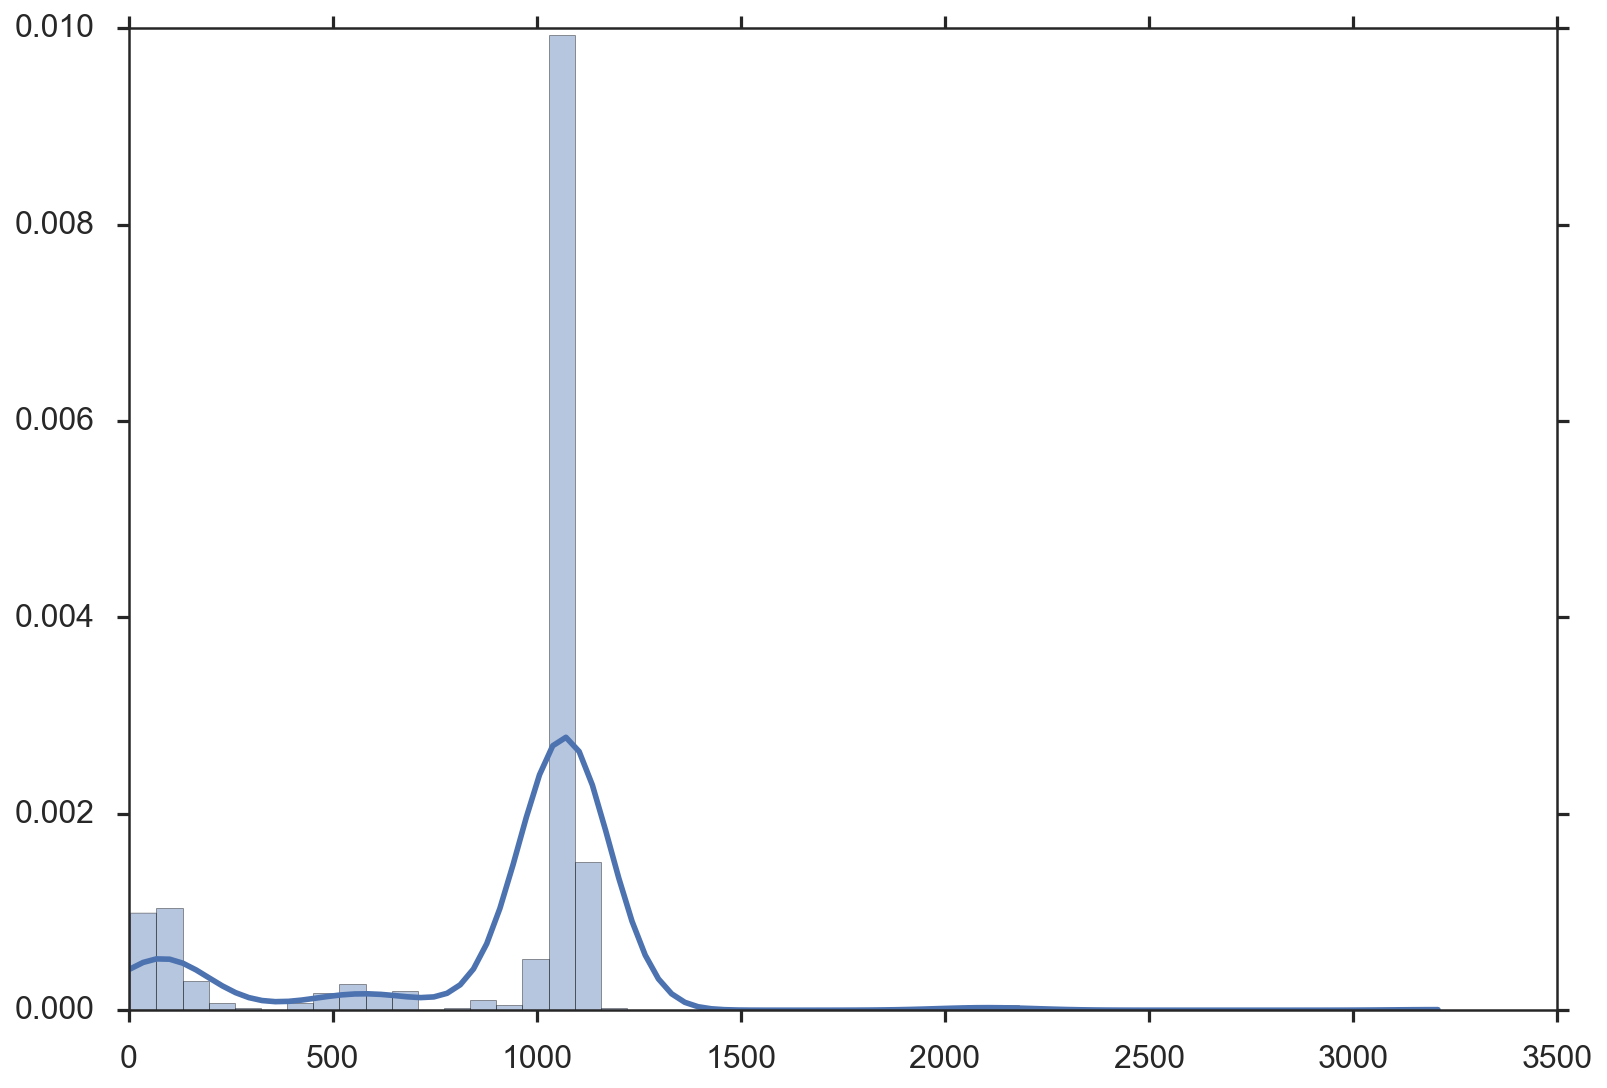

In [16]:
sns.distplot(list(nx.degree(G_full).values()))

Drawing this graph would yield an incomprehensible hairball; it just has too many edges. We need to reduce its complexity.

## Subselecting Good Alignments

We need to prune alignments. We can easily remove aligments below a a threshold `pident` to simplify things. 

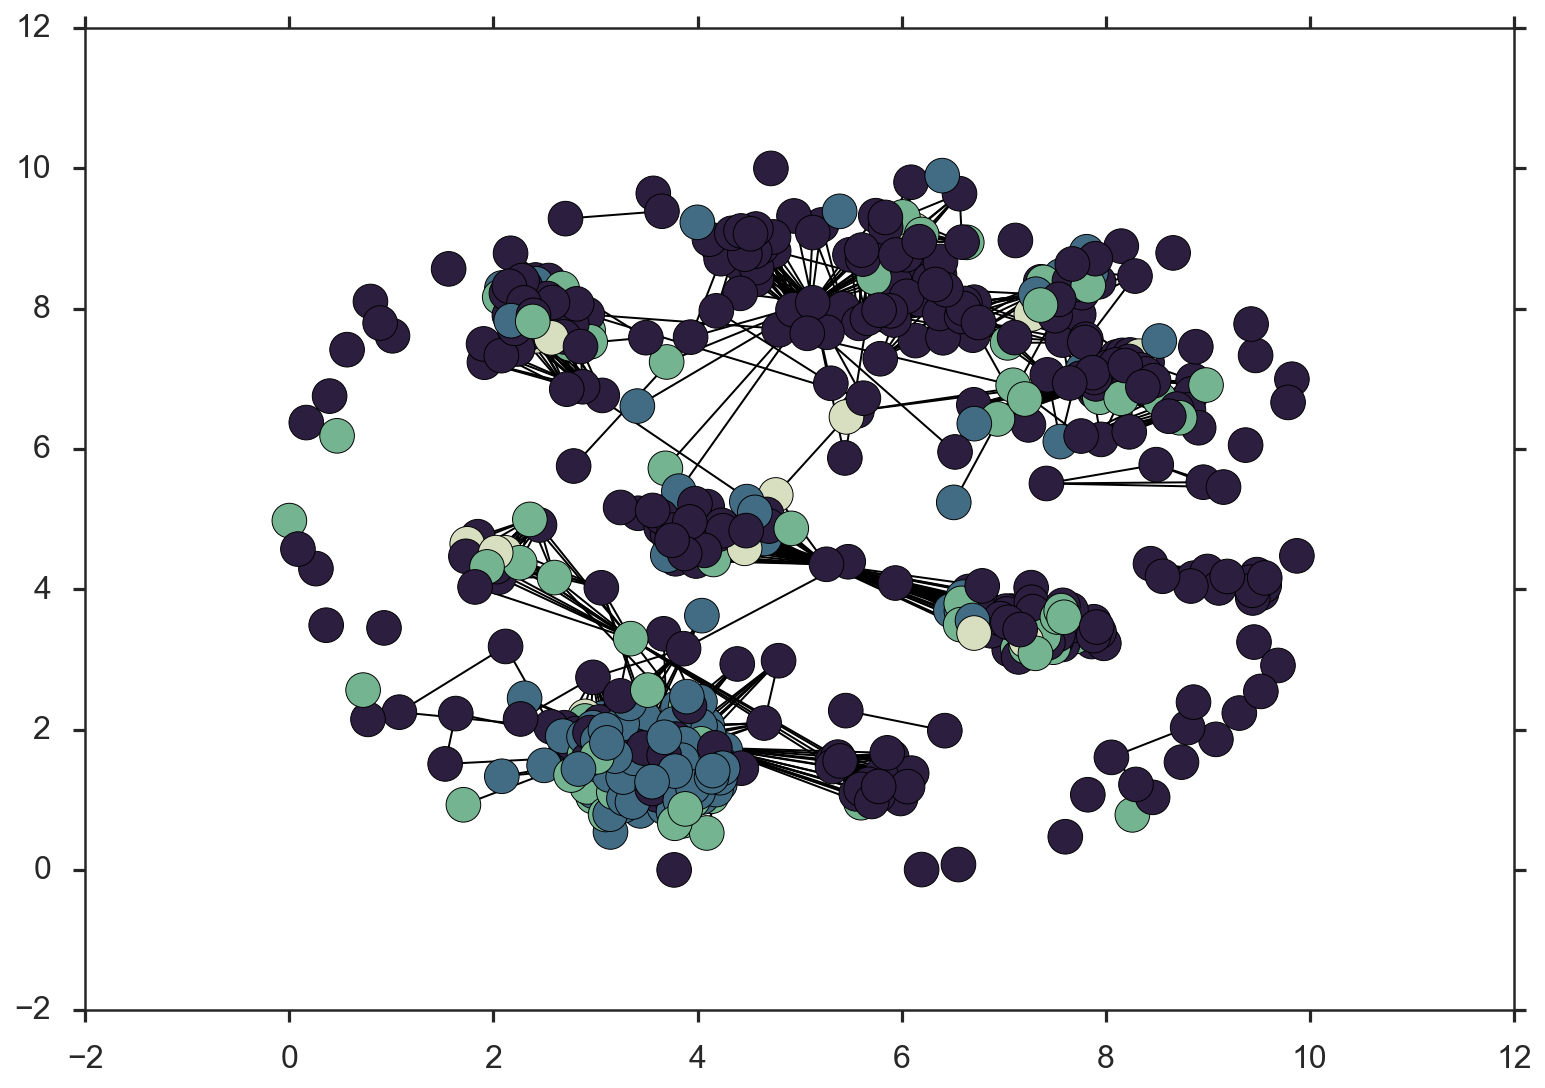

In [21]:
pident90 = get_graph(alignments, alignments.pident > 90, GraphType=nx.Graph)
draw_graph(pident90)

I've colored the nodes based on their *evidence* -- this is a value that Uniprot assigns based on the quality of the evidence for the protein. Bad proteins are colored dark (they likely came from gene predictors), while good proteins (which likely were experimentally confirmed) are the lightest. There is some interesting structure here, namely that proteins of the same evidence tend to group. This is unsurprisingly -- they probably came from the same experiment. Further, if we look at the degree distribution, it shows signs of preferential attachment; this is also unsurprising, as 

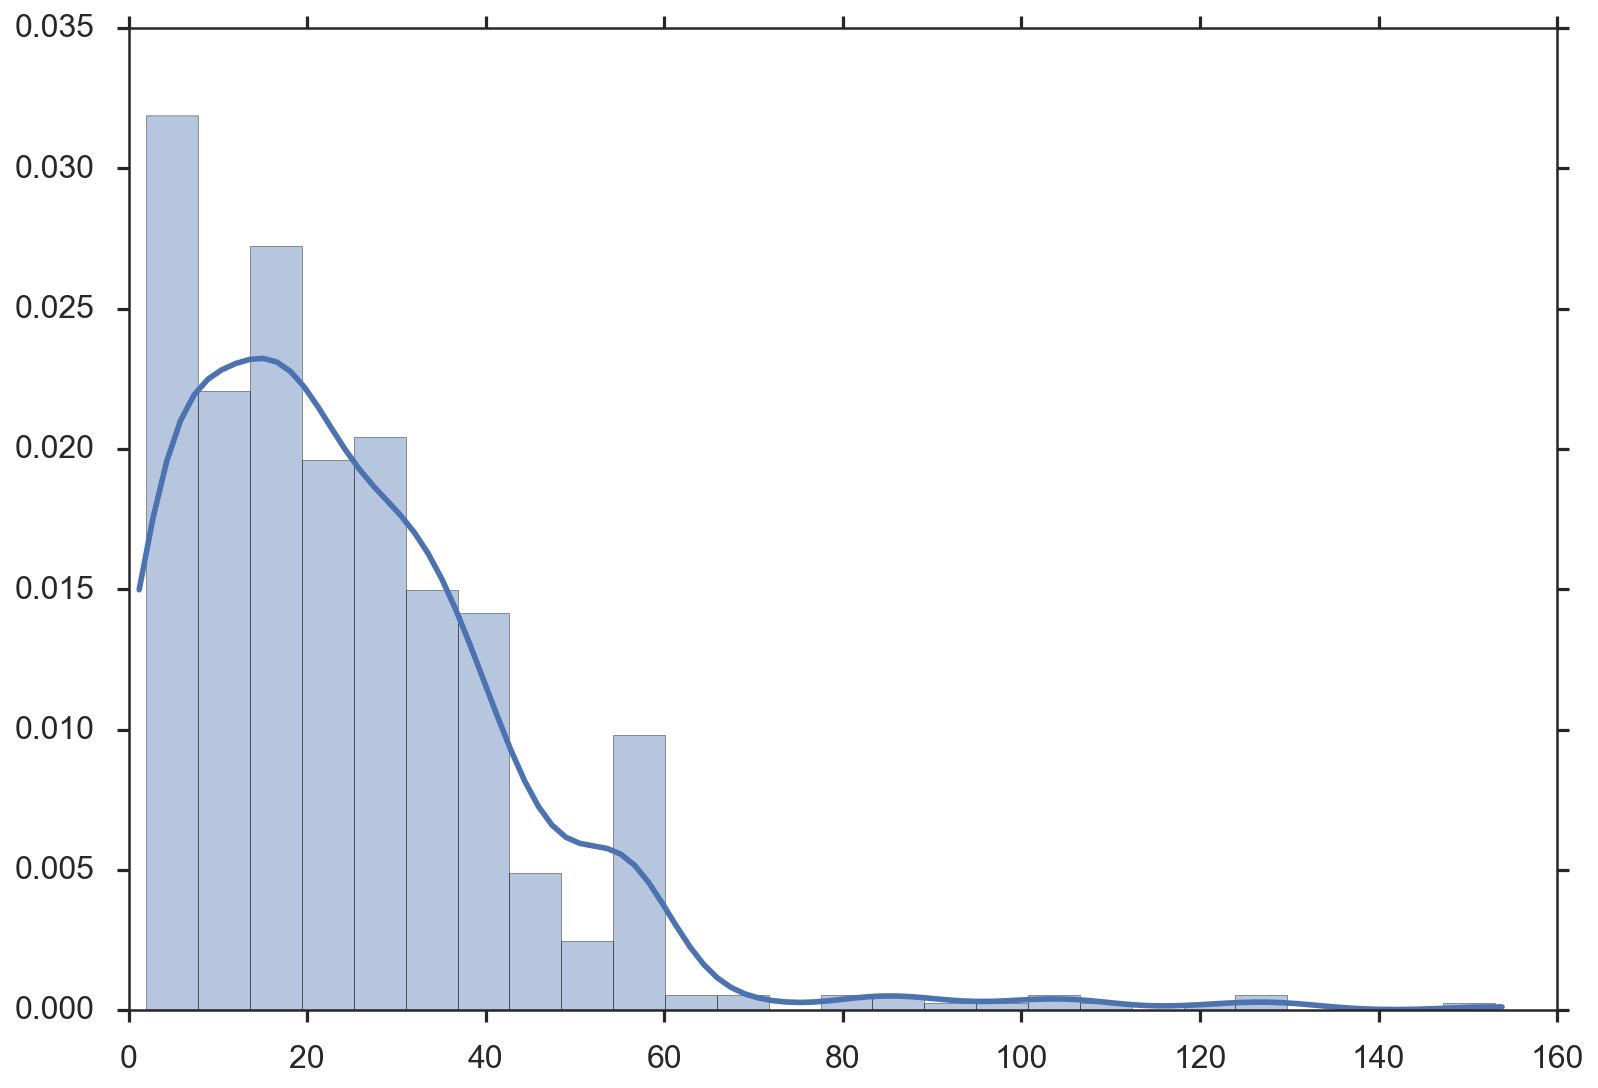

In [22]:
plot_degree_dist(pident90)

In [23]:
import community

In [61]:
def draw_communities(G):
    meta = metadata.ix[G.nodes()]
    cmap = sns.cubehelix_palette(5, start=.5, rot=-.75, as_cmap=True, reverse=True)
    N = len(G.nodes())
    
    partition = community.best_partition(G)
    pos = nx.spring_layout(G, k=0.9, scale=10.0)
    
    size = float(len(set(partition.values())))
    max_rel_size = max([len([nodes for nodes in partition.keys() if partition[nodes] == com]) / N \
                        for com in set(partition.values())])
    print (max_rel_size)
    for com in set(partition.values()) :
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        rel_size = len(list_nodes) / N
        color = [rel_size] * len(list_nodes)
        nx.draw_networkx_nodes(G, pos, list_nodes, node_color=color, cmap=cmap, 
                               vmax=max_rel_size, vmin=0)

    nx.draw_networkx_edges(G, pos)

0.1661392405063291


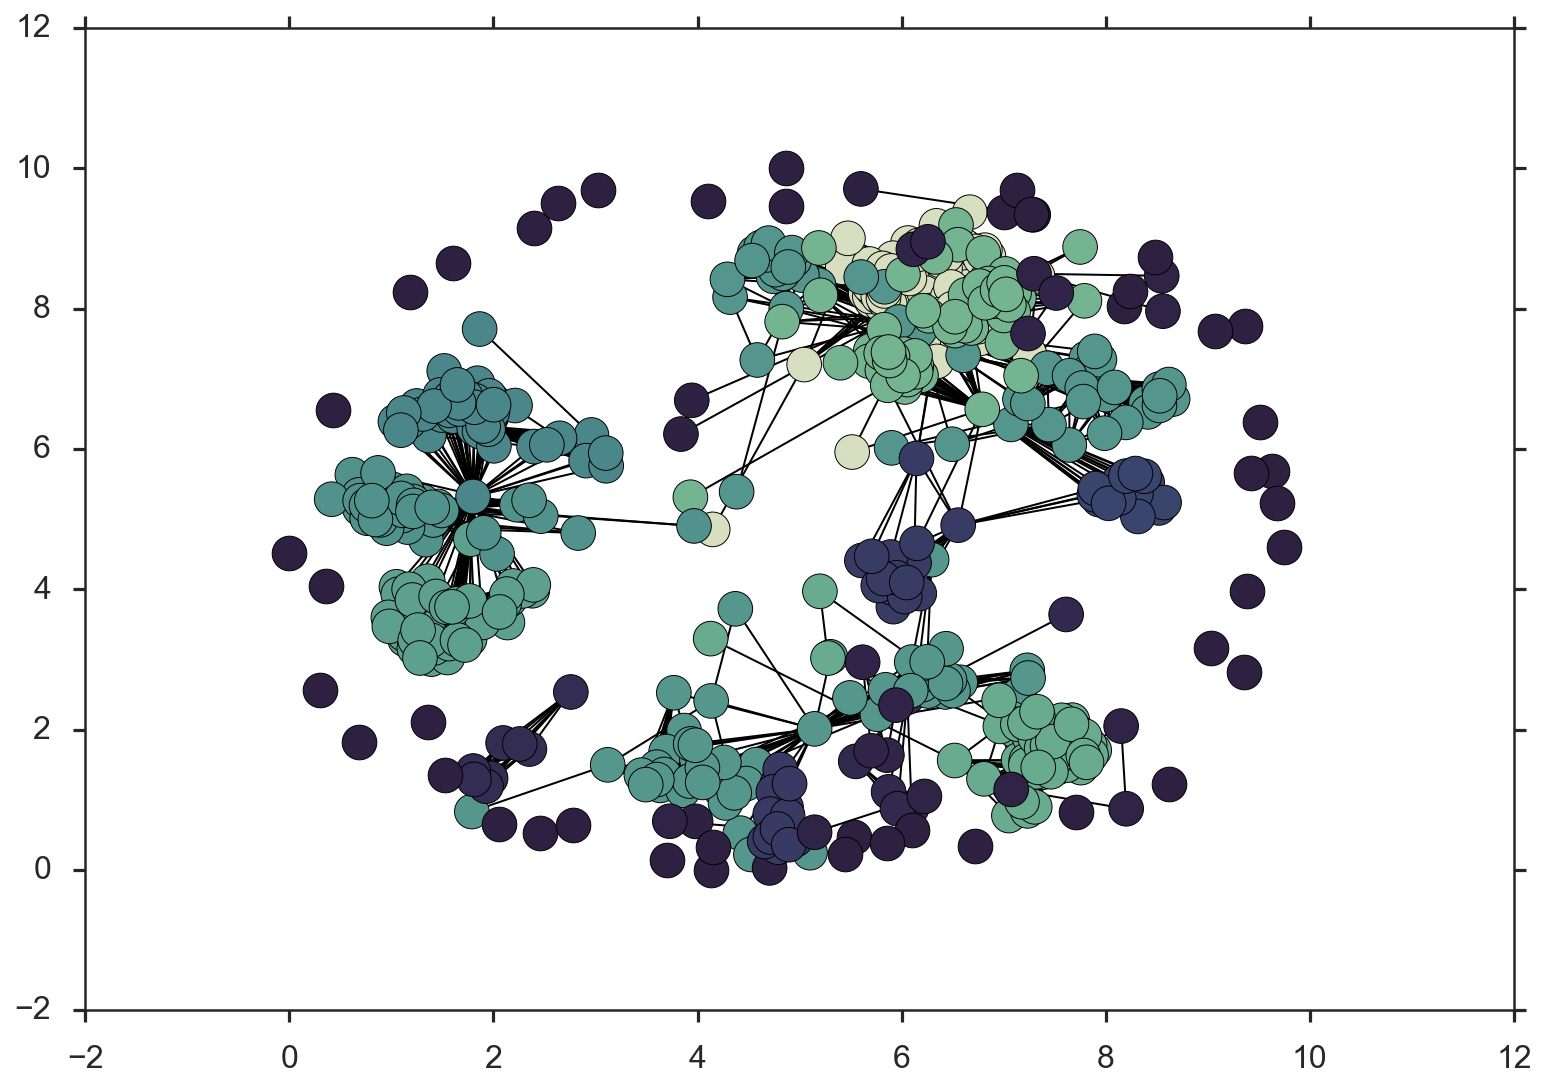

In [62]:
draw_communities(pident90)